In [1]:
NB_NO = 0

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import logging
import scipy.stats as sts
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import os
from pathlib import Path

In [3]:
from arch import arch_model

In [4]:
ini_work_dir = os.getcwd()
# os.chdir('..')

In [5]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from antecedent_fitting import fit_antecedent_params
from local_models import calculate_retraining_garch_forecasts

In [6]:
with open('config.json') as file:
    config = json.load(file)

In [7]:
INPUT = Path(config['files_folders']['processed'])
RES_DIR = Path(config['files_folders']['research_results'])
AP_DIR = Path(config['files_folders']['antecedent_params_sets'])
LOGS_DIR = Path(config['files_folders']['logs'])

In [8]:
METADATA_FILE_NAME = 'current_antecedent_fitting_metadata_wo_seas.pkl'
SUMMARY_TABLE_NAME = 'summary_table_wo_seas'

RESULT_RAW_FILE_NAME = f'apf_wos_raw_result_nb_{NB_NO}'
RESULT_BIG_FILE_NAME = f'apf_wo_seas_result_nb_{NB_NO}'

In [9]:
logger = logging.getLogger(f'apf_wos_nb_{NB_NO}')  # apf == antecedent params fitting

_log_file = LOGS_DIR / '{logger.name}.log'
logging.basicConfig(level=logging.INFO,
                    filename=_log_file,
                    filemode='w',
                    format='%(asctime)s.%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

In [10]:
pd.options.display.precision = 15
pd.options.display.max_colwidth = 300

# Reading data

In [11]:
with open(AP_DIR / f'{METADATA_FILE_NAME}', 'rb') as file:
    data = pickle.load(file)

In [12]:
train = data['train']
test = data['test']
consequent_metaparams = data['consequent_metaparams']
consequent_params_ini = data['consequent_metaparams']['parameters_ini']
antecedent_params_set = data['antecedent_params_set']
clusterization_method = data['clusterization_method']
local_method = data['local_method']
data_to_cluster_train = data['data_to_cluster_train']
data_to_cluster_test = data['data_to_cluster_test']
cluster_sets_conjunction = data['cluster_sets_conjunction']
n_last_points_to_use_for_clustering = data['n_last_points_to_use_for_clustering']
other_fvm_parameters = data['other_fvm_parameters']

In [32]:
clusterization_method

['gaussian']

In [13]:
n_cluster_sets = len(data['clusterization_method'])

p = consequent_metaparams['p']
q = consequent_metaparams['q']

n_train = train.shape[0]
n_test = test.shape[0]

# Main input data plot

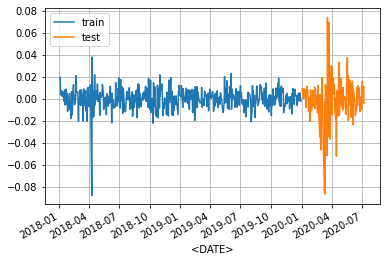

In [14]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

## train & test sizes

In [15]:
print(train.shape[0], test.shape[0])

506 126


# Antecedent params set

In [16]:
len(antecedent_params_set)

108

In [17]:
# antecedent_params_set = antecedent_params_set[0:1]

In [18]:
len(antecedent_params_set)

108

In [19]:
# for _antecedent_params in antecedent_params_set:
#     _centers = _antecedent_params['centers']
#     _variances = _antecedent_params['variances']
#     _n_clusters = _antecedent_params['n_clusters']
    
#     for i in range(_n_clusters):
#         _range = np.arange(-20, 20, .01)
#         _data = sts.norm(_centers[i], _variances[i] ** .5).pdf(_range)

#         plt.plot(_range, _data, label=f'cluster #{i + 1}')
    
#     plt.title(_antecedent_params)
#     plt.legend()
#     plt.grid()
#     plt.show()

# Algorithm parameters

In [20]:
use_multiprocessing = True
do_feeding = False

# Fitting

In [21]:
result = None

In [22]:
%%time

result = fit_antecedent_params(train,
                               test,
                               consequent_metaparams=consequent_metaparams,
                               consequent_params_ini=consequent_params_ini,
                               antecedent_params_set=antecedent_params_set,
                               clusterization_method=clusterization_method,
                               local_method=local_method,
                               data_to_cluster_train=data_to_cluster_train,
                               data_to_cluster_test=data_to_cluster_test,
                               cluster_sets_conjunction=cluster_sets_conjunction,
                               n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering,
                               n_cluster_sets=n_cluster_sets,
                               other_fvm_parameters=other_fvm_parameters,
                               use_multiprocessing=use_multiprocessing,
                               do_feeding=do_feeding)

CPU times: user 107 ms, sys: 258 ms, total: 364 ms
Wall time: 407 ms


In [23]:
_cur_time = str(pd.Timestamp.today()).replace(':', '-')
print(_cur_time)

with open(f'{RES_DIR}/{RESULT_RAW_FILE_NAME}_{_cur_time}', 'wb') as file:
    pickle.dump(result, file)

2023-04-21 20-55-55.054768


In [24]:
res_df = pd.DataFrame.from_records(result).copy()

In [25]:
if (res_df['status'] != 0).any():
    _text = 'Not all models were fitted'
    logger.warning(_text)
    print(_text)

Not all models were fitted


In [30]:
print(res_df.iloc[0]['traceback'])

Traceback (most recent call last):
  File "/home/vsviyazov/fvm/antecedent_fitting.py", line 137, in _create_cluster_fit_forecast
    fvm = FuzzyVolatilityModel(train,
  File "/home/vsviyazov/fvm/model.py", line 140, in __init__
    raise ValueError(f'Clustering method name {self.clusterization_method} '
ValueError: Clustering method name ['gaussian'] is wrong or method is not implemented; should be one of ('gaussian', 'trapezoidal', 'eTS', 'eClustering')



In [26]:
fitted_antecedent_params = res_df[res_df['rmse'] == res_df['rmse'].min()].iloc[0]['antecedent_params']

IndexError: single positional indexer is out-of-bounds

# Adding some info

In [ ]:
result_big = {'result': result, 'fitted': fitted_antecedent_params}

result_big['train'] = train
result_big['test'] = test
result_big['antecedent_params_set'] = antecedent_params_set
result_big['consequent_metaparams'] = consequent_metaparams
result_big['consequent_params_ini'] = consequent_params_ini
result_big['clusterization_method'] = clusterization_method
result_big['local_method'] = local_method
result_big['data_to_cluster_train'] = data_to_cluster_train
result_big['data_to_cluster_test'] = data_to_cluster_test

In [ ]:
_cur_time = str(pd.Timestamp.today()).replace(':', '-')
print(_cur_time)

with open(f'{RES_DIR}/{RESULT_BIG_FILE_NAME}_{_cur_time}.pkl', 'wb') as file:
    pickle.dump(result_big, file)

## Vanilla GARCH errors

### No retraining

In [ ]:
garch_mean = 'Zero'
garch_dist = 'normal'
garch_vol = 'GARCH'

garch = arch_model(train,
                   mean=garch_mean,
                   vol=garch_vol,
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

In [ ]:
simple_garch_forecasts = garch_fitted.forecast(horizon=n_test, reindex=False).variance.iloc[0].values

In [ ]:
mse = mean_squared_error(simple_garch_forecasts, test ** 2, squared=True)
rmse = mean_squared_error(simple_garch_forecasts, test ** 2, squared=False)
mape = mean_absolute_percentage_error(simple_garch_forecasts, test ** 2)

garch_errors = {'mse': mse, 'rmse': rmse, 'mape': mape}
garch_errors

In [ ]:
result['Vanilla GARCH n/r errors'] = garch_errors

### W/ retraining

In [ ]:
retraining_garch_forecasts = calculate_retraining_garch_forecasts(train, test,
                                                                  mean=garch_mean,
                                                                  vol=garch_vol,
                                                                  p=p,
                                                                  q=q,
                                                                  dist=garch_dist)

In [ ]:
_mse = mean_squared_error(retraining_garch_forecasts, test ** 2, squared=True)
_rmse = mean_squared_error(retraining_garch_forecasts, test ** 2, squared=False)
_mape = mean_absolute_percentage_error(retraining_garch_forecasts, test ** 2)

retr_garch_errors = {'mse': _mse, 'rmse': _rmse, 'mape': _mape}
retr_garch_errors

In [ ]:
result['Vanilla GARCH w/r errors'] = retr_garch_errors

# Dumping

## into a single file

In [ ]:
cur_time = str(pd.Timestamp.today().floor('s')).replace(':', '-')
print(cur_time)

with open(f'{RES_DIR}/fitting_consequent_params_seasonal_result_{cur_time}.pkl', 'wb') as file:
    pickle.dump(result, file)

## into a table

In [ ]:
# summary = pd.DataFrame(columns=['Time',
#                                 'p', 'q',
#                                 'Start date', 'Train size', 'Test size',
#                                 '# clusters', 'Centers', 'Variances',
#                                 'MSE', 'Vanilla GARCH MSE (no retraining)', 'Vanilla GARCH MSE (w/ retraining)'])

In [ ]:
summary_pkl_loc = f'{RES_DIR}/{summary_table_name}.pkl'

summary = pd.read_pickle(summary_pkl_loc)

new_entries = []

_garch_nr_mse = result['Vanilla GARCH n/r errors']['mse']
_garch_wr_mse = result['Vanilla GARCH w/r errors']['mse']

for i in range(len(result['fvms'])):
    _antecedent_params = result['antecedent_params_set'][i]
    _centers = _antecedent_params['centers']
    _vars = _antecedent_params['variances']
    _n_clusters = _antecedent_params['n_clusters']
    
    _mse = result['mses'][i]
    
    new_entry = {
        'Time': cur_time,
        'p': p,
        'q': q,
        'Start date': train.index.min(),
        'Train size': n_train,
        'Test size': n_test,
        '# clusters': _n_clusters,
        'Centers': _centers,
        'Variances': _vars,
        'MSE': _mse,
        'Vanilla GARCH MSE (no retraining)': _garch_nr_mse,
        'Vanilla GARCH MSE (w/ retraining)': _garch_wr_mse
    }
    
    new_entries.append(new_entry)

summary = summary.append(new_entries, ignore_index=True, verify_integrity=False, sort=False).copy()

summary.to_pickle(f'{RES_DIR}/{summary_table_name}.pkl')
summary.to_excel(f'{RES_DIR}/{summary_table_name}.xlsx')

In [ ]:
# _ini = pd.read_excel(f'files/summary_table_ini_2022-02-05.xlsx')

# Looking at results

In [ ]:
fvms = result['fvms']

In [ ]:
result['mses']

In [ ]:
plt.plot(fvms[0].h[:-1], label='forecast')
plt.plot(input_cut.values ** 2, label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
(fvms[0].hist_output ** .5).plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts ** .5, index=fvms[0].hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

In [ ]:
fvms[0].hist_output.plot(label='forecast', figsize=(15, 8))
pd.Series(simple_garch_forecasts, index=fvms[0].hist_output.index).plot(label='vanilla GARCH(1, 1) (no retraining)')
(input_cut ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()